# Project 2 - Coronavirus

### Abner Hernández Rodríguez

This project consist to estimate the SIR model with the most updated data from WHO.

In [22]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [23]:
#import PDEparams as pde

## Data from World Health Organization
#### Only laboratory-confirmed, exclude clinically diagnose

In [24]:
data = pd.read_csv('CoV2019.csv')
china = data["China"][:27]#data["China"][:27]
days = data["Days"][:27]
total = data["Total"][:27]
deaths_china = data["Death China"][:27]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]

data.head()

,Date of report,Days,Total,China,Death China,Other,Death Outside,Death Globally
0,01/20/20,21,282,278,6,4,0,6
1,01/21/20,22,346,341,6,4,0,6
2,01/23/20,24,581,571,17,7,0,17
3,01/24/20,25,846,830,25,11,0,25
4,01/25/20,26,1320,1297,41,23,0,41


### Ploting raw data

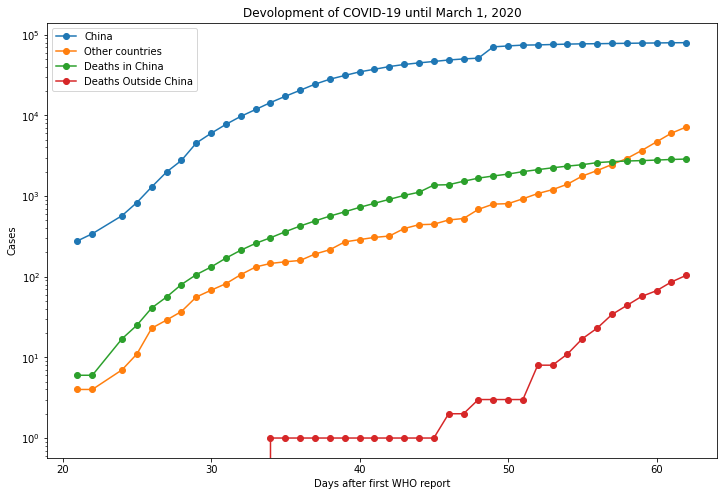

In [25]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()

### Defining the model

We use a SIR model:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

### Initial Conditions

In [26]:
Hubei = 5917*10**4
Guangdong = 11346*10**4
Henan = 9605*10**4
Zhejiang = 5737*10**4
Hunan = 6899*10**4
Anhui = 6324*10**4
Jiangxi = 4648*10**4
N = 56*10**3                        # estimate of people affected by lock down
init_I = 1
init_R = 1

In [27]:
N
#N = S + I + R ----> S = N - I - R

S= N - init_I - init_R
S

55998

In [28]:
Hubei+Guangdong+Henan+Zhejiang+Hunan+Anhui+Jiangxi

504760000

### Objetivo: conseguir un modelo que describa la dinámica de la pandemia en China

In [29]:
# Datos importantes: days, china, deaths_china
days

0     21
1     22
2     24
3     25
4     26
5     27
6     28
7     29
8     30
9     31
10    32
11    33
12    34
13    35
14    36
15    37
16    38
17    39
18    40
19    41
20    42
21    43
22    44
23    45
24    46
25    47
26    48
Name: Days, dtype: int64

### Regresión

Suponiendo que la dinámica de contagio es exponencial, aplicamos la función $ln()$ a la columna de contagios. Después se hace una regresión lineal común, para al final aplicar la función $exp()$ a la predicción de la regresión.

### Entrenamiento

Se genera la matriz 
$ \begin{pmatrix} 1 & 21 \\ \vdots & \vdots \\ 1 & 48 \end{pmatrix} $ 
y después se hace la regresión lineal para obtener los coeficientes.

In [30]:
from sklearn.linear_model import LinearRegression

objetivo = np.log(china.copy())

Mat = np.ones(27)

Mat = pd.DataFrame(Mat)

Mat = pd.concat([Mat, days], axis=1)

lin = LinearRegression().fit(Mat, objetivo)

print(lin.coef_)

l1,lab = lin.coef_


[0.         0.19577874]


Preparamos la matriz para hacer la validación

In [31]:
Mat = np.ones(41)

Mat = pd.DataFrame(Mat)

Mat = pd.concat([Mat, days_total], axis=1)

def modelReg(x,lamda):
    return lamda*x



Graficamos la validación, claramente no es un muy buen modelo.

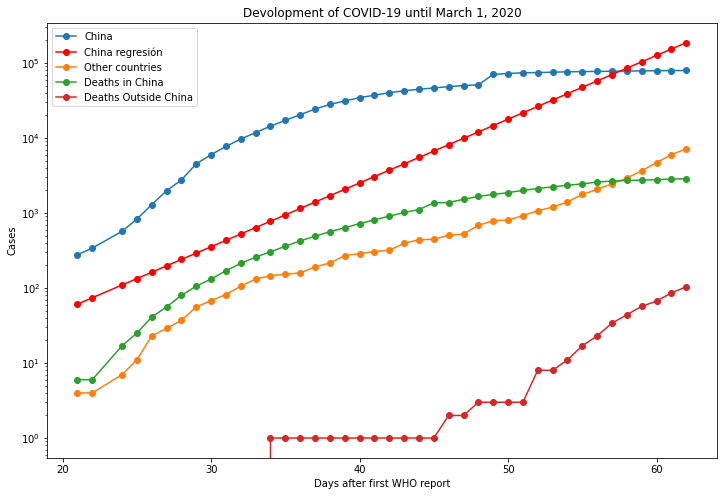

In [32]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")

plt.plot(days_total,np.exp(Mat.dot([l1,lab])), '-o', color = 'red',label="China regresión")

plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()

## Runge-Kutta

El método de Runge-Kutta es un método numérico muy bueno para resolver sistemas de ecuaciones diferenciales, como las del modelo $SIR$.

Aquí se implementa uno. Este lo vimos/hicimos en un curso de Sistemas dinámicos no-lineales hace ya un tiempo.

In [33]:
def RK2_Autonomous(f, p, parNames=[],parValues=[]):
    """Second-order Runge-Kutta method to solve x' = f(x) with U(t[0]) = U0.
    NOTES:
        This version is based on the algorithm presented in "Numerical
        Analysis", 6th Edition, by Burden and Faires, Brooks-Cole, 1997.
    """
    nForc=len(parNames)
    U=np.zeros((p['nSteps'], np.prod(np.shape(p['ic']))),"float64")
    U[0]=p['ic']
    if nForc>0:
        for i in range(p['nSteps']-1):
            for nn in np.arange(nForc):
                p[parNames[nn]]=parValues[nn][i]
            k1 = p['stepSize'] * f( U[i], p) / 2.0
            U[i+1] = U[i] + p['stepSize'] * f( U[i] + k1, p)
    else:
        for i in range(p['nSteps']-1):
            k1 = p['stepSize'] * f( U[i], p) / 2.0
            U[i+1] = U[i] + p['stepSize'] * f( U[i] + k1, p)
    return U.transpose()

Dado que $N = S + R + I$, basta con resolver para $S,I$.

La siguiente función representa el sistema:
$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\end{align}$$

In [34]:
def Dsir(sir,p):
    sp = -p['beta']*(sir[0]*sir[1]/p['n'])
    ip = p['beta']*(sir[0]*sir[1]/p['n'])-p['gam']*sir[1]
    
    return np.array([sp, ip])

p = {'ic':np.array([N-284,278]) ,'beta':1,'gam':1,'n':N,'nSteps':2700,'stepSize':27/2700}

Las siguientes funciones son las curvas solución de $ S $ y $ I $. Pero con la particularidad que se deshace de los valores que no correspondan a los días en la columna $ days $

In [35]:
def funcS(d,bet,ga):
    p['beta']=bet
    p['gam']=ga
    
    sol = RK2_Autonomous(f=Dsir, p=p, parNames=[],parValues=[])
    
    S = sol[0]
    
    comp=[]
    
    for i in range(len(S)-1):
        for j in d:
            if i+21==j:
                comp.append(S[i])
                
    return comp


In [36]:
def funcI(d,bet,ga):
    p['beta']=bet
    p['gam']=ga
    
    sol = RK2_Autonomous(f=Dsir, p=p, parNames=[],parValues=[])
    
    S = sol[1]
    
    comp=[]
    
    for i in range(len(S)-1):
        for j in d:
            if i+21==j:
                comp.append(S[i])
                
    return comp

Usamos curve_fit para ajustar las curvas obtenidas por las funciones anteriores, de este modo obtenemos los parámetros $\gamma,\beta$. Los cuales son los parámetros de la mejor de las soluciones del sistema de ecuaciones.

In [37]:
from scipy.optimize import curve_fit 

param1, pcov = curve_fit(funcI, days, china)

__main__:2: RuntimeWarning: overflow encountered in double_scalars
__main__:3: RuntimeWarning: overflow encountered in double_scalars


Parámetros


$\beta,\gamma$

In [38]:
param1

array([32.56305862,  0.83817213])

Ahora graficamos con los parámetros obtenidos usando Runge-Kutta.

In [39]:
SolI = funcI(days_total,param1[0],param1[1])
SolS = funcS(days_total,param1[0],param1[1])
SolR = []
for i in range(len(SolI)):
    SolR.append(N-SolI[i]-SolS[i])

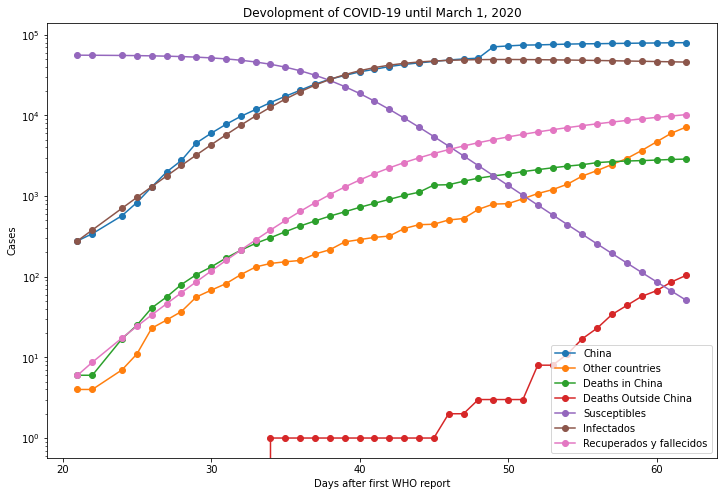

In [40]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")

plt.plot(days_total,SolS, '-o',label="Susceptibles")
plt.plot(days_total,SolI, '-o',label="Infectados")
plt.plot(days_total,SolR, '-o',label="Recuperados y fallecidos")

plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()